In [ ]:
!pip install -q ultralytics opencv-python-headless 

In [ ]:
!git clone https://github.com/aras62/PIE.git
!unzip /content/PIE/annotations/annotations.zip -d /content/PIE
!unzip /content/PIE/annotations/annotations_vehicle.zip -d /content/PIE
!mkdir /kaggle/working/PIE/content

In [ ]:
import os
import cv2
import torch
import numpy as np
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm # Use notebook version if in Kaggle notebook
# from tqdm import tqdm # Use standard if running as .py script
import pickle # To save the processed data easily
from ultralytics import YOLO # Make sure ultralytics is installed
import zipfile

In [ ]:
zip_path = "/kaggle/working/PIE/annotations/annotations.zip"
extract_to = "/kaggle/working/PIE/annotations/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
import cv2
import os
import xml.etree.ElementTree as ET
import numpy as np
import pickle
from ultralytics import YOLO
import torch
from tqdm.notebook import tqdm # Use notebook version for Kaggle
import gc # Garbage collector
import zipfile # For zipping results
import time

# --- Configuration ---
# <<< ADJUST THESE PATHS AND LISTS FOR YOUR SETUP >>>

# --- Paths Adjusted Based on User Input ---
BASE_VIDEO_INPUT_DIR = '/kaggle/input' # Base for video datasets
BASE_ANNOTATION_DIR = '/kaggle/working/PIE/annotations/annotations' # Base dir containing setXX folders with XMLs
# ---

SETS_TO_PROCESS = ['set04'] # Specify ALL sets you want to process

# --- Adjusted Pose Model Path ---
POSE_MODEL_PATH = '/kaggle/input/yolov8x-pose6/pytorch/default/1/yolov8x-pose-p6.pt'
# ---

OUTPUT_PKL_DIR = '/kaggle/working/extracted_poses2' # Directory to save individual PKL files
OUTPUT_ZIP_FILE = '/kaggle/working/all_video_poses.zip' # Final zip file name
# ---

INPUT_SIZE_POSE = 34 # 17 keypoints * 2 coords (x, y)
IOU_THRESHOLD = 0.3 # Minimum IoU to match detection with annotation

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Starting Multi-Video Pose Extraction ---")
print(f"Processing Sets: {SETS_TO_PROCESS}")
print(f"Using Device: {DEVICE}")
print(f"Using Pose Model: {POSE_MODEL_PATH}")
print(f"Individual PKL Output Directory: {OUTPUT_PKL_DIR}")
print(f"Final Zip File: {OUTPUT_ZIP_FILE}")

# --- Create Output Directory ---
os.makedirs(OUTPUT_PKL_DIR, exist_ok=True)
print(f"Ensured output directory exists: {OUTPUT_PKL_DIR}")

# --- Helper Functions (Reused from previous script) ---
def compute_iou(boxA, boxB):
    # ... (implementation remains the same) ...
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA); interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def parse_annotations_all_frames(xml_file):
    # ... (implementation remains the same, including print statements) ...
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
    except (ET.ParseError, FileNotFoundError) as e:
        print(f"\nERROR: Failed parsing {os.path.basename(xml_file)}: {e}")
        return None, None, None
    img_width, img_height = None, None
    try:
        size_elem = root.find('.//original_size')
        if size_elem is not None:
            img_width = int(size_elem.find('width').text)
            img_height = int(size_elem.find('height').text)
        else: raise ValueError("original_size tag not found")
    except Exception as e: print(f"Warning: Could not parse original_size in {os.path.basename(xml_file)}: {e}")
    ped_tracks = {}
    all_required_frames = set()
    pedestrian_tracks_found = 0
    for track in root.findall('.//track[@label="pedestrian"]'):
        pedestrian_tracks_found += 1
        ped_id = None; track_id_elem = track.find('.//attribute[@name="id"]');
        if track_id_elem is not None: ped_id = track_id_elem.text
        for box in track.findall('.//box'):
            current_box_id_elem = box.find('.//attribute[@name="id"]')
            current_box_id = current_box_id_elem.text if current_box_id_elem is not None else ped_id
            if current_box_id is None and ped_id is None:
                 id_elem_box = box.find('.//attribute[@name="id"]');
                 if id_elem_box is not None: current_box_id = id_elem_box.text
                 else: continue
            if ped_id is None: ped_id = current_box_id
            try:
                frame = int(box.get('frame')); all_required_frames.add(frame)
                xtl, ytl, xbr, ybr = float(box.get('xtl')), float(box.get('ytl')), float(box.get('xbr')), float(box.get('ybr'))
                if ped_id not in ped_tracks: ped_tracks[ped_id] = {}
                ped_tracks[ped_id][frame] = {'bbox_pixels': [xtl, ytl, xbr, ybr]}
            except Exception as e: print(f"Warning: Error parsing box in {os.path.basename(xml_file)} F:{box.get('frame')} P:{ped_id}: {e}")
    if pedestrian_tracks_found == 0: print(f"Warning: No pedestrian tracks found in {os.path.basename(xml_file)}"); return {}, set(), (img_width, img_height) if img_width else None
    if not ped_tracks: print(f"Warning: No valid pedestrian boxes extracted from {os.path.basename(xml_file)}"); return {}, set(), (img_width, img_height) if img_width else None
    # Return sorted list for potentially better sequential access later (though seeking is used)
    return ped_tracks, sorted(list(all_required_frames)), (img_width, img_height)

# --- Main Extraction Logic ---

# 1. Load YOLO Pose Model (Load ONCE)
print(f"\nLoading POSE model: {POSE_MODEL_PATH}...")
start_load_time = time.time()
try:
    if not os.path.exists(POSE_MODEL_PATH):
        if POSE_MODEL_PATH not in YOLO.EXPORT_FORMATS_POSE: raise FileNotFoundError(f"Pose model not found: {POSE_MODEL_PATH}")
        else: print(f"Model file not found locally at {POSE_MODEL_PATH}. Attempting download.")
    pose_model = YOLO(POSE_MODEL_PATH)
    pose_model.to(DEVICE)
    print(f"POSE model loaded successfully in {time.time() - start_load_time:.2f} seconds.")
except Exception as e: print(f"\nFATAL ERROR: Could not load pose model: {e}"); exit()

# List to keep track of generated PKL files for zipping
generated_pkl_files = []
total_start_time = time.time()

# 2. Loop through Sets
print("\n--- Starting Set Processing ---")
for set_id in tqdm(SETS_TO_PROCESS, desc="Overall Sets Progress"):
    print(f"\n--- Processing Set: {set_id} ---")
    set_start_time = time.time()
    annotation_set_dir = os.path.join(BASE_ANNOTATION_DIR, set_id)
    video_set_input_dir_name = f"pie-{set_id}"
    video_set_input_path = os.path.join(BASE_VIDEO_INPUT_DIR, video_set_input_dir_name)

    if not os.path.isdir(annotation_set_dir): print(f"Warning: Annotation dir not found, skipping set: {annotation_set_dir}"); continue
    if not os.path.isdir(video_set_input_path): print(f"Warning: Video Input dir not found, skipping set: {video_set_input_path}"); continue

    try:
        xml_files = sorted([f for f in os.listdir(annotation_set_dir) if f.endswith('_annt.xml')])
        if not xml_files: print(f"No annotation files ('*_annt.xml') found in {annotation_set_dir}. Skip set."); continue
    except Exception as e: print(f"Error listing annotations in {annotation_set_dir}: {e}. Skip set."); continue
    print(f"Found {len(xml_files)} annotation files in {set_id}.")

    # 3. Loop through Videos in the Set
    for xml_filename in tqdm(xml_files[13:], desc=f"Videos in {set_id}", leave=False):
        video_id = xml_filename.replace('_annt.xml', '')
        video_start_time = time.time()
        print(f"\n  Processing Video: {video_id} (Set: {set_id})...")

        annotation_xml_path = os.path.join(annotation_set_dir, xml_filename)
        video_path = os.path.join(video_set_input_path, f"{video_id}.mp4")

        if not os.path.exists(video_path): print(f"  Warning: Video file not found, skipping: {video_path}"); continue

        # --- Per-Video Processing ---
        ped_tracks, required_frames, ann_dims = parse_annotations_all_frames(annotation_xml_path)
        if ped_tracks is None or required_frames is None: print(f"  Error parsing annotations for {video_id}. Skip."); continue
        if not required_frames: print(f"  Info: No annotated frames for {video_id}. Skip."); continue

        video_pose_data = {}
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): print(f"  Error opening video {video_path}. Skip."); continue
        vid_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)); vid_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if ann_dims and (ann_dims[0] != vid_width or ann_dims[1] != vid_height): print(f"  Warn: Ann dims {ann_dims} != Vid dims ({vid_width}x{vid_height})!")
        if not (vid_width > 0 and vid_height > 0): print(f"  Error: Invalid video dimensions for {video_id}. Skip."); cap.release(); continue

        frames_processed_count = 0; errors_reading_frame = 0; errors_yolo_inference = 0; errors_keypoint_processing = 0
        for frame_num in tqdm(required_frames, desc=f"Extracting {video_id}", leave=False, unit="frame"):
            frame_idx_cv = frame_num - 1
            if not (0 <= frame_idx_cv < total_frames_video): continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_cv); ret, frame = cap.read();
            if not ret: errors_reading_frame += 1; continue

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            try: results = pose_model(frame_rgb, device=DEVICE, verbose=False, half=torch.cuda.is_available())
            except Exception as e: print(f"\nErr YOLO F:{frame_num} V:{video_id}: {e}. Skip."); errors_yolo_inference += 1; del frame_rgb, frame; gc.collect(); torch.cuda.empty_cache(); continue

            detections = []; num_persons_detected = 0
            if results and hasattr(results[0], 'boxes') and results[0].boxes is not None and \
               hasattr(results[0], 'keypoints') and results[0].keypoints is not None and \
               hasattr(results[0].boxes, 'xyxy') and hasattr(results[0].keypoints, 'data'):
                boxes = results[0].boxes.xyxy.cpu().numpy(); keypoints = results[0].keypoints.data.cpu().numpy()
                if keypoints is not None and boxes is not None and len(boxes) == keypoints.shape[0]:
                     num_persons_detected = len(boxes)
                     for i in range(len(boxes)): detections.append({'box': boxes[i], 'kps': keypoints[i]})

            frame_pose_data = {}
            peds_in_this_frame = [(pid, data_map[frame_num]['bbox_pixels']) for pid, data_map in ped_tracks.items() if frame_num in data_map]

            if peds_in_this_frame:
                if not detections:
                    for ped_id, _ in peds_in_this_frame: frame_pose_data[ped_id] = np.zeros(INPUT_SIZE_POSE, dtype=np.float32)
                else:
                    for ped_id, ann_bbox_pixels in peds_in_this_frame:
                        best_iou = 0.0; best_match_kps = None
                        for det in detections:
                            iou = compute_iou(ann_bbox_pixels, det['box'])
                            if iou > best_iou: best_iou = iou; best_match_kps = det['kps']
                        pose_vector = np.zeros(INPUT_SIZE_POSE, dtype=np.float32)
                        if best_match_kps is not None and best_iou >= IOU_THRESHOLD:
                            try:
                                if best_match_kps.ndim == 2 and best_match_kps.shape[1] == 3:
                                    norm_kps = []; num_keypoints = best_match_kps.shape[0]
                                    for kp_idx in range(num_keypoints): x, y = best_match_kps[kp_idx, 0], best_match_kps[kp_idx, 1]; norm_kps.extend([x / vid_width, y / vid_height])
                                    if len(norm_kps) == INPUT_SIZE_POSE: pose_vector = np.array(norm_kps, dtype=np.float32)
                                    else: errors_keypoint_processing += 1
                                else: errors_keypoint_processing += 1
                            except Exception as e: errors_keypoint_processing += 1
                        frame_pose_data[ped_id] = pose_vector

            if frame_pose_data: video_pose_data[frame_num] = frame_pose_data; frames_processed_count += 1

            # Memory Cleanup
            del frame_rgb, frame, results;
            if 'detections' in locals(): del detections;
            if 'boxes' in locals(): del boxes;
            if 'keypoints' in locals(): del keypoints;
            if 'frame_pose_data' in locals(): del frame_pose_data;
            gc.collect(); torch.cuda.empty_cache();

        # --- End of Frame Loop ---
        cap.release()
        print(f"    Finished {video_id}. Proc {frames_processed_count}/{len(required_frames)} frames in {time.time() - video_start_time:.2f} sec. RdErr:{errors_reading_frame}, YoloErr:{errors_yolo_inference}, KpErr:{errors_keypoint_processing}")

        # --- *** CORRECTED FILENAME FOR SAVING *** ---
        if video_pose_data:
            # Include set_id in the filename
            output_filename = f"{set_id}_{video_id}_poses.pkl"
            output_pkl_path = os.path.join(OUTPUT_PKL_DIR, output_filename)
            try:
                 # Save in the format {unique_video_key: {frame_num: {ped_id: pose_vector}}}
                 # Using a unique key like set_id + video_id might be good practice
                 unique_video_key = f"{set_id}_{video_id}"
                 with open(output_pkl_path, 'wb') as f: pickle.dump({unique_video_key: video_pose_data}, f)
                 print(f"    Saved: {output_pkl_path}")
                 generated_pkl_files.append(output_pkl_path)
            except Exception as e: print(f"  Error saving PKL for {video_id}: {e}")
        else: print(f"    No pose data extracted for {video_id}, PKL file not saved.")
        # --- *** END CORRECTION *** ---
        del ped_tracks, required_frames, video_pose_data, ann_dims; gc.collect()

    # --- End of Video Loop ---
    print(f"--- Finished Set: {set_id} in {time.time() - set_start_time:.2f} seconds ---")

# --- End of Set Loop ---
print(f"\n--- Finished processing all sets in {time.time() - total_start_time:.2f} seconds ---")

# 4. Zip all generated PKL files
print(f"\n--- Zipping Generated PKL Files ---")
if not generated_pkl_files: print("No PKL files generated to zip.")
else:
    print(f"Found {len(generated_pkl_files)} PKL files to zip.")
    try:
        with zipfile.ZipFile(OUTPUT_ZIP_FILE, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for pkl_file_path in tqdm(generated_pkl_files, desc="Zipping"): zipf.write(pkl_file_path, arcname=os.path.basename(pkl_file_path))
        print(f"Successfully created zip file: {OUTPUT_ZIP_FILE}")
        print("\nFiles in the zip archive:");
        with zipfile.ZipFile(OUTPUT_ZIP_FILE, 'r') as zipf_read: zipf_read.printdir()
    except Exception as e: print(f"Error creating zip file: {e}")

print("\n--- Full Pose Extraction and Zipping Script Finished ---")

--- Verifying Pose PKL File ---
Verifying Set: set04, Video: video_0010
PKL Path: /kaggle/working/extracted_poses2/set04_video_0010_poses.pkl
Video Path: /kaggle/input/pie-set04/video_0010.mp4
Annotation XML Path: /kaggle/working/PIE/annotations/annotations/set04/video_0010_annt.xml

[1] Loading PKL file...
 -> PKL file loaded successfully.

[2] Checking Data Structure...
 -> Top level is a dictionary: OK
 -> Unique video key 'set04_video_0010' found: OK
 -> Data for video ID is a dictionary: OK
 -> Found pose data for 5003 frames.

[3] Checking Pose Vector Content (Sample)...


Checking Frames:   0%|          | 0/5003 [00:00<?, ?it/s]

 -> Checked 5003 frames containing 16249 pose vectors.
 -> Data types and shapes seem consistent.
 -> Found 10754 zero vectors (66.18% of total)
 -> Min/Max coord value (non-zero vectors): [0.0000, 1.0000]
 -> Coordinate value range OK.

[4] Visualizing 5 Random Samples...
 -> Video dimensions for un-normalization: 1920x1080
 -> Selecting 5 random non-zero samples...
   - Visualizing Frame: 14559, Pedestrian: 4_10_1520


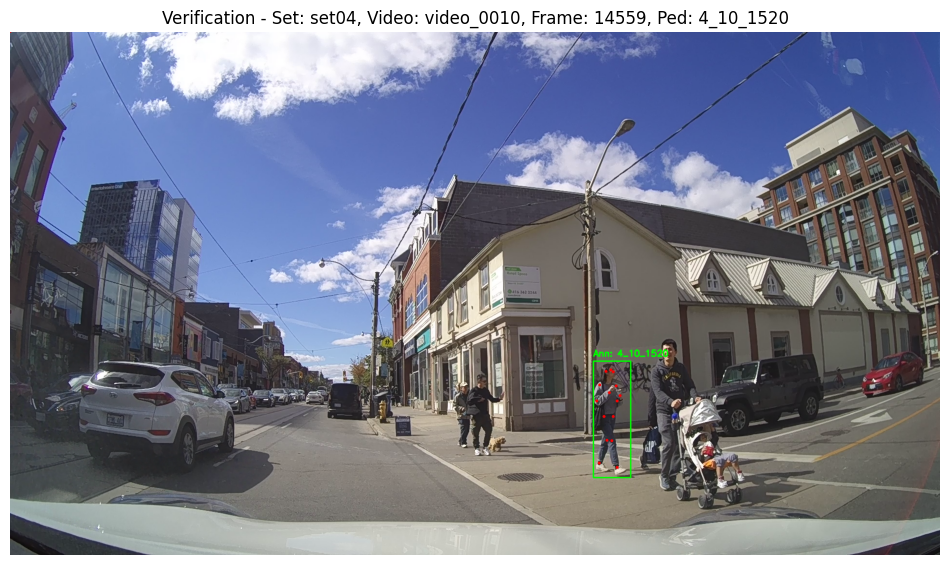

   - Visualizing Frame: 5704, Pedestrian: 4_10_1490


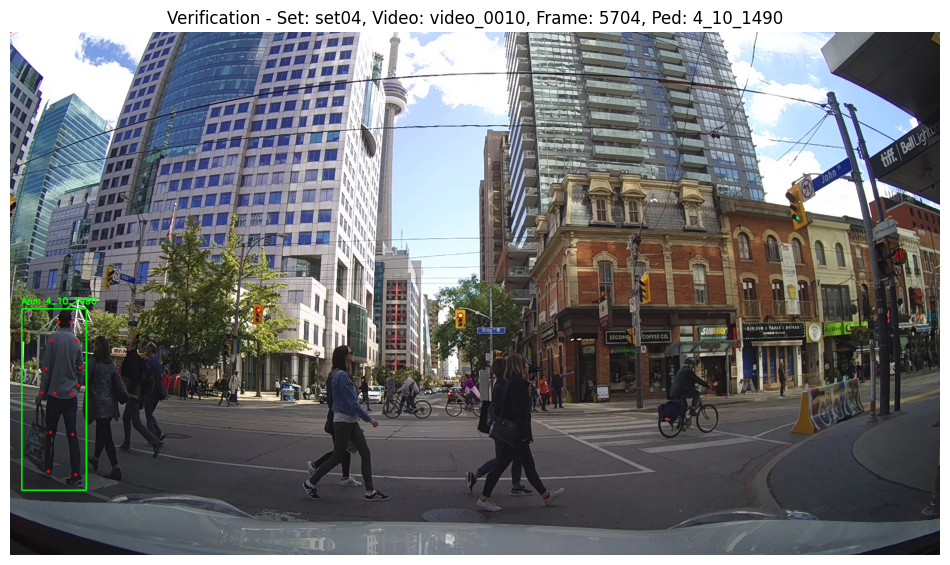

   - Visualizing Frame: 14540, Pedestrian: 4_10_1519


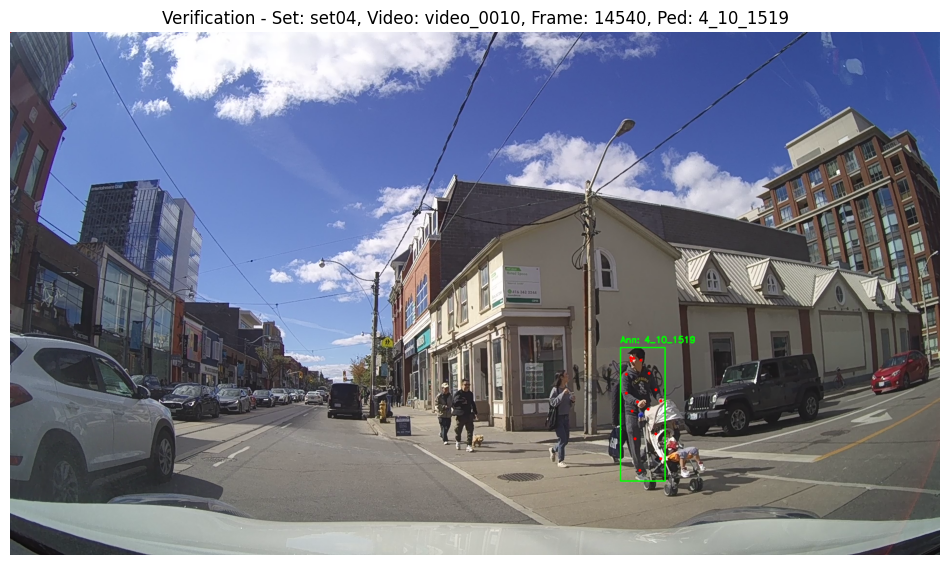

   - Visualizing Frame: 5522, Pedestrian: 4_10_1492


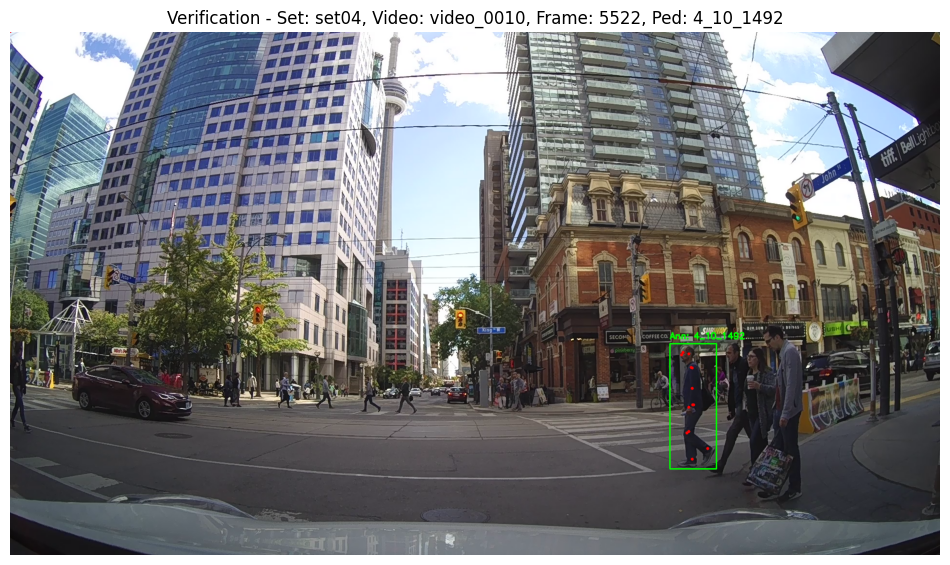

   - Visualizing Frame: 5882, Pedestrian: 4_10_1495


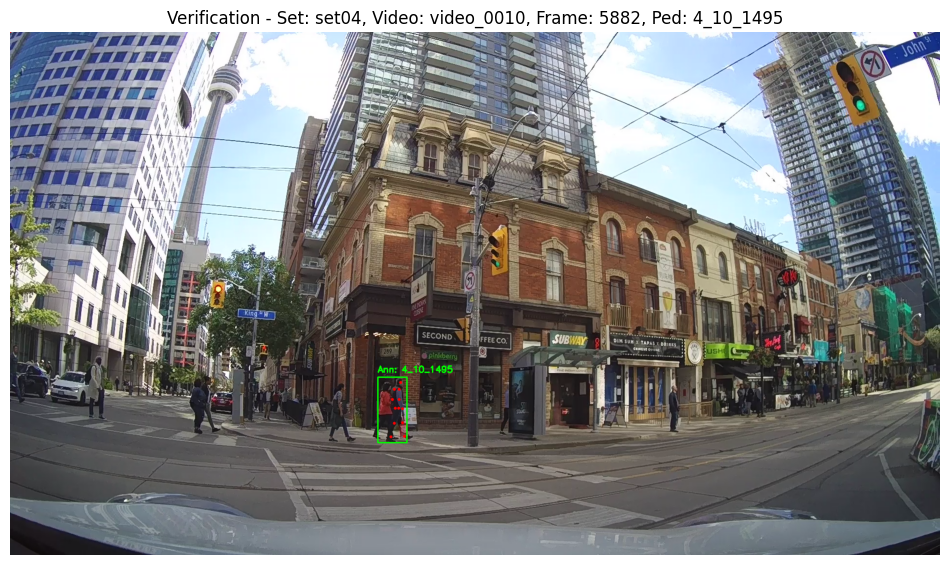


--- Verification Script Finished ---


In [2]:
import cv2
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import torch
import csv
import random
import pickle
from tqdm.notebook import tqdm

# --- Configuration ---
# <<< --- SET THESE TO THE SPECIFIC FILE YOU WANT TO VERIFY --- >>>
SET_ID_TO_VERIFY = 'set04'
VIDEO_ID_TO_VERIFY = 'video_0010' # Example: Verify video 2 from set 1
# <<< --- END SPECIFIC FILE SELECTION --- >>>

# Base directories (Assuming they are the same as in the generation script)
BASE_VIDEO_INPUT_DIR = '/kaggle/input'
BASE_ANNOTATION_DIR = '/kaggle/working/PIE/annotations/annotations'
OUTPUT_PKL_DIR = '/kaggle/working/extracted_poses2' # Where the individual PKLs were saved

# --- Construct Paths based on SET_ID and VIDEO_ID ---
# Construct the unique key expected inside the PKL
unique_video_key = f"{SET_ID_TO_VERIFY}_{VIDEO_ID_TO_VERIFY}"
# Construct the PKL filename
pkl_filename = f"{unique_video_key}_poses.pkl"
PKL_FILE_PATH = os.path.join(OUTPUT_PKL_DIR, pkl_filename)

# Construct video and annotation paths
video_set_input_dir_name = f"pie-{SET_ID_TO_VERIFY}"
video_set_input_path = os.path.join(BASE_VIDEO_INPUT_DIR, video_set_input_dir_name)
VIDEO_PATH = os.path.join(video_set_input_path, f"{VIDEO_ID_TO_VERIFY}.mp4")
ANNOTATION_XML_PATH = os.path.join(BASE_ANNOTATION_DIR, SET_ID_TO_VERIFY, f"{VIDEO_ID_TO_VERIFY}_annt.xml")
# ---

# --- Verification Parameters ---
EXPECTED_POSE_LEN = 34 # e.g., 17 keypoints * 2 coordinates
EXPECTED_DTYPE = np.float32
COORD_MIN_EXPECTED = -0.1 # Allow slight negative for normalization edge cases
COORD_MAX_EXPECTED = 1.1 # Allow slight > 1 for normalization edge cases
NUM_VISUALIZATIONS = 5 # How many random frames/peds to visualize

print(f"--- Verifying Pose PKL File ---")
print(f"Verifying Set: {SET_ID_TO_VERIFY}, Video: {VIDEO_ID_TO_VERIFY}")
print(f"PKL Path: {PKL_FILE_PATH}")
print(f"Video Path: {VIDEO_PATH}")
print(f"Annotation XML Path: {ANNOTATION_XML_PATH}")

# --- Helper Function to get BBox from XML for visualization (Unchanged) ---
def get_bbox_from_xml(xml_file, target_frame, target_ped_id):
    """Parses XML to find the bbox for a specific pedestrian in a specific frame (Revised)."""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
    except (ET.ParseError, FileNotFoundError) as e:
        print(f"Error reading/parsing XML {xml_file}: {e}")
        return None, None

    img_width, img_height = None, None
    try:
        size_elem = root.find('.//original_size')
        if size_elem is not None:
            img_width = int(size_elem.find('width').text)
            img_height = int(size_elem.find('height').text)
    except Exception: pass

    target_bbox = None
    for track in root.findall('.//track[@label="pedestrian"]'):
        for box in track.findall('.//box'):
            if box.get('frame') == str(target_frame):
                id_attribute = box.find(f'.//attribute[@name="id"]')
                if id_attribute is not None and id_attribute.text == target_ped_id:
                    try:
                        xtl, ytl, xbr, ybr = float(box.get('xtl')), float(box.get('ytl')), float(box.get('xbr')), float(box.get('ybr'))
                        target_bbox = [xtl, ytl, xbr, ybr]
                        return target_bbox, (img_width, img_height)
                    except Exception as e:
                        print(f"Warning: Error parsing bbox F:{target_frame} P:{target_ped_id} - {e}")
                        return None, (img_width, img_height) # Return error on parsing fail

    if target_bbox is None:
        print(f"Warning: Annotation box not found for Frame: {target_frame}, Pedestrian: {target_ped_id}")
    return target_bbox, (img_width, img_height)


# --- 1. Load the PKL File ---
print(f"\n[1] Loading PKL file...")
if not os.path.exists(PKL_FILE_PATH):
    raise FileNotFoundError(f"PKL file not found at: {PKL_FILE_PATH}")

try:
    with open(PKL_FILE_PATH, 'rb') as f:
        loaded_data = pickle.load(f)
    print(" -> PKL file loaded successfully.")
except Exception as e:
    raise IOError(f"Error loading PKL file: {e}")

# --- 2. Basic Structure Checks ---
print(f"\n[2] Checking Data Structure...")
if not isinstance(loaded_data, dict):
    raise TypeError(f"Expected loaded data to be a dictionary, but got {type(loaded_data)}")
print(f" -> Top level is a dictionary: OK")

# --- Check for the unique video key ---
if unique_video_key not in loaded_data:
    raise KeyError(f"Expected key '{unique_video_key}' not found in the loaded dictionary.")
print(f" -> Unique video key '{unique_video_key}' found: OK")

# --- Access the actual pose data using the unique key ---
video_pose_data = loaded_data[unique_video_key]
if not isinstance(video_pose_data, dict):
     raise TypeError(f"Expected data for video '{unique_video_key}' to be a dictionary, but got {type(video_pose_data)}")
print(f" -> Data for video ID is a dictionary: OK")

total_frames_in_pkl = len(video_pose_data)
print(f" -> Found pose data for {total_frames_in_pkl} frames.")
if total_frames_in_pkl == 0:
    print("Warning: PKL file contains no frame data for this video.")
    exit() # Exit gracefully if no data to check further


# --- 3. Detailed Content Checks (Iterate through a sample or all) ---
# (This section remains unchanged as it operates on video_pose_data)
print(f"\n[3] Checking Pose Vector Content (Sample)...")
min_val = float('inf'); max_val = float('-inf')
zero_vector_count = 0; total_pose_vectors = 0; checked_frame_count = 0
expected_shape = (EXPECTED_POSE_LEN,)
frames_to_check = list(video_pose_data.keys())

for frame_num in tqdm(frames_to_check, desc="Checking Frames"):
    if not isinstance(frame_num, int): print(f"Warning: Frame key {frame_num} is not an integer."); continue
    frame_data = video_pose_data[frame_num]
    if not isinstance(frame_data, dict): print(f"Warning: Data for frame {frame_num} is not a dictionary."); continue
    checked_frame_count += 1
    for ped_id, pose_vector in frame_data.items():
        total_pose_vectors += 1
        if not isinstance(pose_vector, np.ndarray): raise TypeError(f"Error F:{frame_num} P:{ped_id}: Type {type(pose_vector)}, expected ndarray.")
        if pose_vector.dtype != EXPECTED_DTYPE: print(f"Warning F:{frame_num} P:{ped_id}: dtype {pose_vector.dtype}, expected {EXPECTED_DTYPE}.")
        if pose_vector.shape != expected_shape: raise ValueError(f"Error F:{frame_num} P:{ped_id}: Shape {pose_vector.shape}, expected {expected_shape}.")
        if np.all(pose_vector == 0): zero_vector_count += 1
        else:
            current_min, current_max = np.min(pose_vector), np.max(pose_vector)
            min_val, max_val = min(min_val, current_min), max(max_val, current_max)
            if current_min < COORD_MIN_EXPECTED or current_max > COORD_MAX_EXPECTED:
                 print(f"Warning F:{frame_num} P:{ped_id}: Value range [{current_min:.4f}, {current_max:.4f}] outside expected [{COORD_MIN_EXPECTED}, {COORD_MAX_EXPECTED}]")

print(f" -> Checked {checked_frame_count} frames containing {total_pose_vectors} pose vectors.")
print(f" -> Data types and shapes seem consistent.")
if total_pose_vectors > 0:
    percent_zero = (zero_vector_count / total_pose_vectors) * 100
    print(f" -> Found {zero_vector_count} zero vectors ({percent_zero:.2f}% of total)")
    if max_val > -float('inf'):
        print(f" -> Min/Max coord value (non-zero vectors): [{min_val:.4f}, {max_val:.4f}]")
        if min_val >= COORD_MIN_EXPECTED and max_val <= COORD_MAX_EXPECTED: print(" -> Coordinate value range OK.")
        else: print(" -> WARNING: Coordinate value range outside expected bounds.")
    else: print(" -> All vectors were zero, min/max range not applicable.")


# --- 4. Visualization Check ---
# (This section remains largely unchanged, uses correctly assigned video_pose_data)
print(f"\n[4] Visualizing {NUM_VISUALIZATIONS} Random Samples...")

# Check necessary file paths first
path_checks_ok = True
if not os.path.exists(VIDEO_PATH):
    print(f" -> Skipping visualization: Video file not found at {VIDEO_PATH}"); path_checks_ok = False
if not os.path.exists(ANNOTATION_XML_PATH):
     print(f" -> Skipping visualization: Annotation XML not found at {ANNOTATION_XML_PATH}"); path_checks_ok = False
if total_pose_vectors == 0:
     print(f" -> Skipping visualization: No pose vectors found in PKL."); path_checks_ok = False

if path_checks_ok:
    cap_vis = cv2.VideoCapture(VIDEO_PATH)
    if not cap_vis.isOpened():
        print(f" -> Skipping visualization: Could not open video file {VIDEO_PATH}")
    else:
        vid_width = int(cap_vis.get(cv2.CAP_PROP_FRAME_WIDTH)); vid_height = int(cap_vis.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames_video = int(cap_vis.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f" -> Video dimensions for un-normalization: {vid_width}x{vid_height}")
        if not (vid_width > 0 and vid_height > 0):
             print(" -> Skipping visualization: Invalid video dimensions obtained.")
             cap_vis.release()
        else:
            valid_frame_ped_pairs = []
            for fn, p_data in video_pose_data.items():
                for pid, pv in p_data.items():
                    if not np.all(pv == 0): # Only non-zero poses
                        if 0 <= (fn - 1) < total_frames_video: valid_frame_ped_pairs.append((fn, pid))
                        # else: print(f"Skipping frame {fn} for visualization (out of video bounds).") # Optional warning

            if not valid_frame_ped_pairs: print(" -> No non-zero pose vectors found to visualize.")
            else:
                num_to_show = min(NUM_VISUALIZATIONS, len(valid_frame_ped_pairs))
                print(f" -> Selecting {num_to_show} random non-zero samples...")
                samples_to_visualize = random.sample(valid_frame_ped_pairs, num_to_show)

                for frame_num_vis, ped_id_vis in samples_to_visualize:
                    print(f"   - Visualizing Frame: {frame_num_vis}, Pedestrian: {ped_id_vis}")
                    frame_idx_cv = frame_num_vis - 1
                    cap_vis.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_cv); ret_vis, frame_vis = cap_vis.read()
                    if not ret_vis: print(f"     Error reading frame {frame_num_vis}."); continue

                    bbox_vis, _ = get_bbox_from_xml(ANNOTATION_XML_PATH, frame_num_vis, ped_id_vis)
                    pose_vector_vis = video_pose_data[frame_num_vis][ped_id_vis] # Access correctly assigned data
                    vis_img = frame_vis.copy()

                    if bbox_vis: # Draw Annotation Box (Green)
                        xtl, ytl, xbr, ybr = [int(c) for c in bbox_vis]
                        cv2.rectangle(vis_img, (xtl, ytl), (xbr, ybr), (0, 255, 0), 2)
                        cv2.putText(vis_img, f"Ann: {ped_id_vis}", (xtl, ytl - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                    if not np.all(pose_vector_vis == 0): # Draw Keypoints (Red)
                        num_kps = len(pose_vector_vis) // 2
                        for kp_idx in range(num_kps):
                            norm_x, norm_y = pose_vector_vis[kp_idx*2], pose_vector_vis[kp_idx*2+1]
                            pixel_x, pixel_y = int(norm_x * vid_width), int(norm_y * vid_height)
                            if 0 <= pixel_x < vid_width and 0 <= pixel_y < vid_height:
                                 cv2.circle(vis_img, (pixel_x, pixel_y), 3, (0, 0, 255), -1)

                    plt.figure(figsize=(12, 8)); plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                    plt.title(f"Verification - Set: {SET_ID_TO_VERIFY}, Video: {VIDEO_ID_TO_VERIFY}, Frame: {frame_num_vis}, Ped: {ped_id_vis}")
                    plt.axis('off'); plt.show();

                cap_vis.release() # Release video capture outside the sample loop

print("\n--- Verification Script Finished ---")